
# Goal: Quickly predict the ON and OFF values for sequences in bulk by using trained model. 

### Instructions: Please change the file_name in the second code block to sequences you are interested in predicting the ON and OFF values for. The format should be a .csv file with one column, and the column should not have a header or column title.

In [13]:
# import statements 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.python.saved_model import tag_constants
%matplotlib inline

import keras as keras
from keras.models import load_model

from pysster.One_Hot_Encoder import One_Hot_Encoder
from sklearn import preprocessing
from keras.utils import to_categorical

# Part 1: Load in bulk sequence data. 
## Change file_name here!

In [14]:
# enter a .csv with sequences
data_dir = 'toehold_sequences/'
file_name = 'example_switches.csv' # CHANGE FILENAME!
data_df = pd.read_csv(data_dir + file_name,sep=',', header=None)
data_df.rename(columns = {0:'switch_sequence'}, inplace = True) 
data_df.head(3)

,switch_sequence
0,AAAAAAAAAAAAAAAAAATGGAAAACAGTTAACAGAGGAGAAACTG...
1,AAAAAAAAAAAAATGGAAAACAGTTACTAAAACAGAGGAGATTAGT...
2,AAAAAAAAATTACTACTATTGTTAATTTAGAACAGAGGAGACTAAA...


In [15]:
toehold_seqs = data_df['switch_sequence']
seq_len = len(toehold_seqs[0])
print('Toehold length: ', seq_len)
num_seqs = len(data_df)
print('Number of sequences: ', num_seqs)

Toehold length:  59
Number of sequences:  99


# Part 2. Transform Data. One-hot encode sequences and extact target on and off values.

In [16]:
# create DNA alphabet- may need to change if you have RNA toeholds. Just change to 'AUCG' in the first line
alph_letters = sorted('ATCG')
alph = list(alph_letters)

# one-hot encode with pysster (very fast and simple encoding)  
one = One_Hot_Encoder(alph_letters)
def _get_one_hot_encoding(seq):
    one_hot_seq = one.encode(seq)                         
    return one_hot_seq

# now convert the data into one_hot_encoding 
input_col_name = 'switch_sequence'
X = np.stack([_get_one_hot_encoding(s) for s in toehold_seqs]).astype(np.float32)

print('input shape: ', X.shape)

input shape:  (99, 59, 4)


# Part 3. Load in final model. 

In [17]:
model_dir = 'trained_model/'
final_model_path = model_dir + 'final_trained_model.h5'
final_weights_path = model_dir + 'final_trained_model_weights.h5'
model = load_model(final_model_path)
model.load_weights(final_weights_path)

In [18]:
# visually inspect architecture
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 59, 4)        0                                            
__________________________________________________________________________________________________
conv_0 (Conv1D)                 (None, 59, 10)       210         input_2[0][0]                    
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 59, 5)        155         conv_0[0][0]                     
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 295)          0           conv_1[0][0]                     
__________________________________________________________________________________________________
dropout_4 

# Part 4. Use model to predict ON and OFF values per sequence.


In [19]:
predictions = model.predict(X)

# Part 5. Save ON and OFF values per sequence. 

In [20]:
on_preds = predictions[0]
off_preds = predictions[1]

data_df['on_preds'] = np.reshape(on_preds, [num_seqs,])
data_df['off_preds'] = np.reshape(off_preds, [num_seqs,])

In [21]:
data_df.to_csv(data_dir + 'predicted_values.csv') # change if you would like to save to different directory
data_df.head()

,switch_sequence,on_preds,off_preds
0,AAAAAAAAAAAAAAAAAATGGAAAACAGTTAACAGAGGAGAAACTG...,0.653590,0.218043
1,AAAAAAAAAAAAATGGAAAACAGTTACTAAAACAGAGGAGATTAGT...,0.619147,0.251494
2,AAAAAAAAATTACTACTATTGTTAATTTAGAACAGAGGAGACTAAA...,0.107543,0.037083
3,AAAAAAAATAACGTAGGACTACTACTTGGAAACAGAGGAGATCCAA...,0.085016,0.040952
4,AAAAAAAATGGAAAACAGTTACTAATATGTAACAGAGGAGAACATA...,0.113206,0.035373


Text(0, 0.5, 'Number of Sequences')

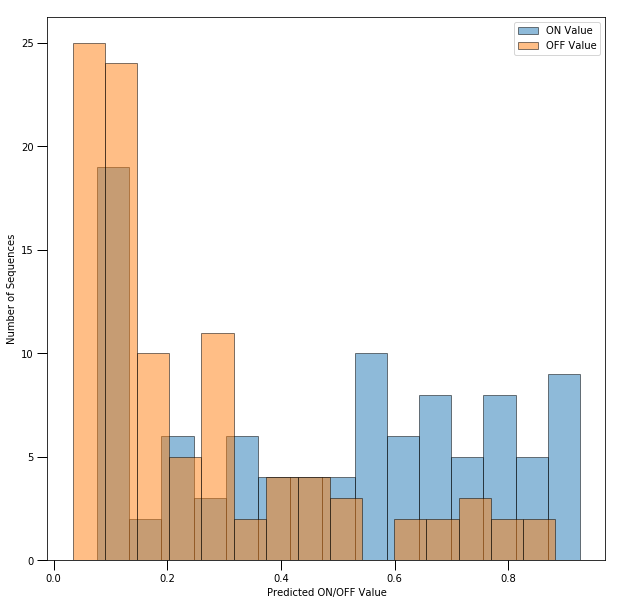

In [22]:
# Plot ON and OFF values on the same histogram
fig, ax = plt.subplots(figsize = (10, 10))
plt.hist(data_df['on_preds'], bins = 15, alpha = 0.5, color = 'tab:blue', edgecolor = 'black')
plt.hist(data_df['off_preds'], bins = 15, alpha = 0.5, color = 'tab:orange', edgecolor = 'black')
plt.legend(('ON Value', 'OFF Value'))
ax.tick_params(length = 10, width = 1)
ax.set_xlabel('Predicted ON/OFF Value')
ax.set_ylabel('Number of Sequences')

In [23]:
# calculate ON/OFF ratios for each sequence
onoff_rat = data_df['on_preds'] - data_df['off_preds']
print(onoff_rat[0:5])

0    0.435547
1    0.367653
2    0.070460
3    0.044064
4    0.077832
dtype: float32


Text(0, 0.5, 'Number of Sequences')

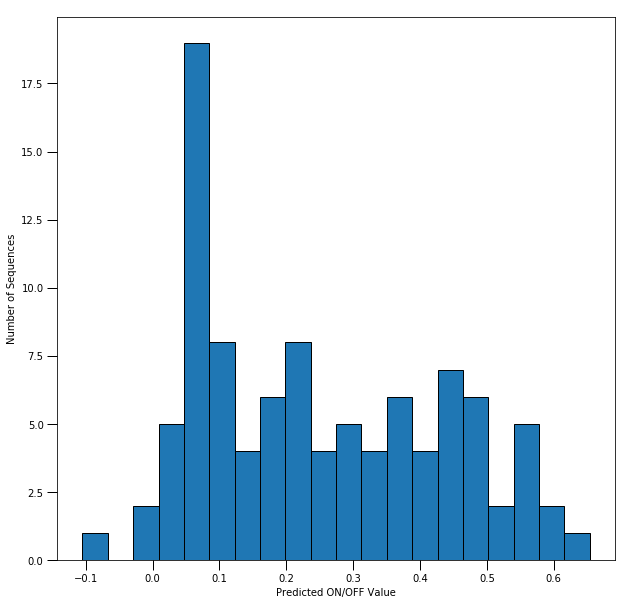

In [24]:
# plot ON/OFF ratios as a histogram
fig, ax = plt.subplots(figsize = (10, 10))
plt.hist(onoff_rat, bins = 20, color = 'tab:blue', edgecolor = 'black')
ax.tick_params(length = 10, width = 1)
ax.set_xlabel('Predicted ON/OFF Value')
ax.set_ylabel('Number of Sequences')